In [15]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [4]:
np.random.seed(0)

data = pd.read_csv('state_action.csv', index_col=None)
data_size = 200000
selected_idx = np.random.randint(0, len(data)-1, size=data_size)
data_select = data[data.index.isin(selected_idx)][['start_type', 'act_num', 'mode_num', 'end_type']]

In [5]:
latent_dims = []
input_dim = 0
hidden_dim = 512
N = 10
for column in data_select.columns:
    print(f'Attribute Type = {column}')
    print(f'Num of Categories in Attribute = {data_select[column].nunique()}')
    latent_dims.append([N, data_select[column].nunique()])
    input_dim += data_select[column].nunique()

Attribute Type = start_type
Num of Categories in Attribute = 5
Attribute Type = act_num
Num of Categories in Attribute = 9
Attribute Type = mode_num
Num of Categories in Attribute = 9
Attribute Type = end_type
Num of Categories in Attribute = 5


In [6]:
data_loader = DataLoader(data_select[['start_type', 'act_num', 'mode_num', 'end_type']].values, batch_size=250, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Hyperparameters
latent_dim = 100
num_epochs = 24
input_dim = 4
output_dim = 28  # Total number of categories (5 + 9 + 9 + 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_critic = 5

class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, output_dim)
        )
        self.category_sizes = [5, 9, 9, 5]
        
    def forward(self, z):
        output = self.model(z)
        start = 0
        processed_output = []
        for size in self.category_sizes:
            end = start + size
            category_output = nn.functional.softmax(output[:, start:end], dim=1)
            processed_output.append(category_output)
            start = end
        return torch.cat(processed_output, dim=1)

class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.model(x)

generator = Generator(latent_dim, output_dim).to(device)
critic = Critic(output_dim).to(device)

# Optimizers
lr = 0.0001
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

# Gradient penalty
def compute_gradient_penalty(critic, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand(real_samples.size())
    
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    fake = torch.ones(d_interpolates.size(), device=device, requires_grad=False)
    
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [105]:
# Training loop
lambda_gp = 1
category_sizes = [5, 9, 9, 5]

for epoch in range(num_epochs):
    for i, real_data in enumerate(data_loader):
        batch_size = real_data.size(0)
        real_data = real_data.long().to(device)
        
        # Train Critic
        optimizer_C.zero_grad()
        
        # Generate fake data
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_data = generator(z)
        
        # Real data processing
        real_data_encoded = torch.zeros(batch_size, output_dim, device=device)
        start = 0
        for j, size in enumerate(category_sizes):
            real_data_encoded[:, start + real_data[:, j]] = 1
            start += size
        
        # Compute critic loss
        real_validity = critic(real_data_encoded)
        fake_validity = critic(fake_data.detach())
        gradient_penalty = compute_gradient_penalty(critic, real_data_encoded, fake_data.detach())
        
        critic_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        critic_loss.backward()
        optimizer_C.step()
        
        # Train Generator every n_critic iterations
        if i % n_critic == 0:
            optimizer_G.zero_grad()
            
            # Generate fake data
            fake_data = generator(z)
            fake_validity = critic(fake_data)
            
            # Compute generator loss
            generator_loss = -torch.mean(fake_validity)
            generator_loss.backward()
            optimizer_G.step()
        

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Critic Loss: {critic_loss.item():.4f} Generator Loss: {generator_loss.item():.4f}")

# Generate sample data
with torch.no_grad():
    z = torch.randn(batch_size, latent_dim, device=device)
    sample = generator(z)
    print("Sample data:")
    for i in range(20):
        categories = []
        start = 0
        for size in category_sizes:
            end = start + size
            category = torch.argmax(sample[i, start:end]).item()
            categories.append(category)
            start = end
        print(categories)

# Print distribution of generated samples
print("\nDistribution of generated samples:")
for i, size in enumerate(category_sizes):
    start = sum(category_sizes[:i])
    end = start + size
    dist = torch.sum(sample[:, start:end], dim=0)
    print(f"Category {i+1}: {dist.tolist()}")

Epoch [1/24] Critic Loss: -9.5132 Generator Loss: -1.8818
Epoch [2/24] Critic Loss: -8.6267 Generator Loss: -2.2250
Epoch [3/24] Critic Loss: -8.7140 Generator Loss: -2.3359
Epoch [4/24] Critic Loss: -8.3658 Generator Loss: -2.3995
Epoch [5/24] Critic Loss: -7.5147 Generator Loss: -2.4494
Epoch [6/24] Critic Loss: -8.6626 Generator Loss: -2.5048
Epoch [7/24] Critic Loss: -7.9015 Generator Loss: -2.4827
Epoch [8/24] Critic Loss: -8.9888 Generator Loss: -2.5387
Epoch [9/24] Critic Loss: -7.5694 Generator Loss: -2.5136
Epoch [10/24] Critic Loss: -8.0396 Generator Loss: -2.5313
Epoch [11/24] Critic Loss: -8.6274 Generator Loss: -2.5821
Epoch [12/24] Critic Loss: -8.2084 Generator Loss: -2.5750
Epoch [13/24] Critic Loss: -9.0494 Generator Loss: -2.5513
Epoch [14/24] Critic Loss: -9.0738 Generator Loss: -2.5342
Epoch [15/24] Critic Loss: -8.5942 Generator Loss: -2.5442
Epoch [16/24] Critic Loss: -8.6515 Generator Loss: -2.5032
Epoch [17/24] Critic Loss: -9.1964 Generator Loss: -2.5049
Epoch 

In [106]:
# Generate sample data
samples = []
with torch.no_grad():
    z = torch.randn(3000, latent_dim, device=device)
    sample = generator(z)
    print("Sample data:")
    for i in range(3000):
        categories = []
        start = 0
        for size in category_sizes:
            end = start + size
            category = torch.argmax(sample[i, start:end]).item()
            categories.append(category)
            start = end
        samples.append(categories)
        

# Print distribution of generated samples
print("\nDistribution of generated samples:")
for i, size in enumerate(category_sizes):
    start = sum(category_sizes[:i])
    end = start + size
    dist = torch.sum(sample[:, start:end], dim=0)
    print(f"Category {i+1}: {dist.tolist()}")

Sample data:

Distribution of generated samples:
Category 1: [782.1312866210938, 749.912109375, 716.841064453125, 0.0031412383541464806, 751.1124267578125]
Category 2: [385.62152099609375, 420.41778564453125, 398.53607177734375, 405.52691650390625, 402.6280212402344, 372.70440673828125, 229.32032775878906, 0.0019258286338299513, 385.2430114746094]
Category 3: [391.0007629394531, 383.4546203613281, 397.5328369140625, 397.8799743652344, 390.387451171875, 385.78692626953125, 394.87615966796875, 259.08074951171875, 0.0005404620314948261]
Category 4: [755.300537109375, 732.5770874023438, 764.8480224609375, 0.0007712212391197681, 747.273681640625]


In [107]:
with torch.no_grad():
    z = torch.randn(3000, latent_dim, device=device)
    sample = generator(z)

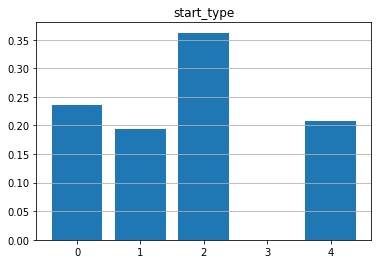

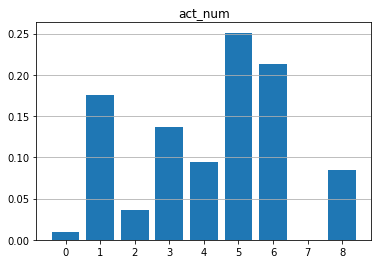

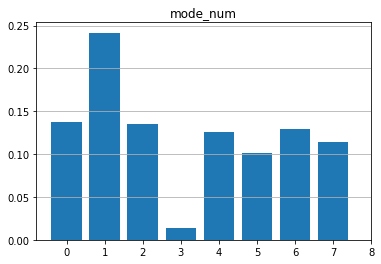

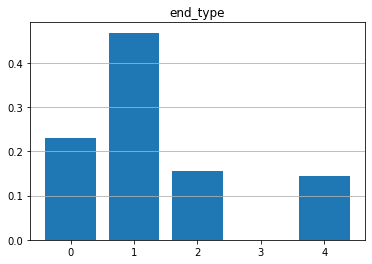

In [103]:
for idx, (K , name) in enumerate(zip([5, 9, 9, 5], ['start_type', 'act_num', 'mode_num', 'end_type'])):
    end = start + K
    unique, counts = np.unique(np.array(samples)[:,idx], return_counts=True)
    plt.figure(figsize=(6,3.5))
    plt.bar(unique, counts/counts.sum())
    plt.title(name)
    plt.xticks(np.arange(K))
    plt.grid(axis = 'y')
    plt.savefig(f'{name}_gan.png', dpi=300)
    plt.show()
    plt.close()
    start = end